# Simplified neural network

In [1]:
using Plots
using Random
using LinearAlgebra
using Statistics
using StatsBase

## Track part

In [2]:
mutable struct track
    road::Array{Int64}
end

function track(n::Int64)
    track(zeros(n,n))
end

function right!(tr::track,pos::Int64,dir::Int64,larg::Int64,h::Int64)
    r = tr.road
    dir2 = dir%4
    if dir2 == 0
        for i in 0:larg-1
            r[pos + i*n : pos + (larg-1) + i*n] = [h+larg - j for j in 1:larg] #ones(larg)*(h+larg-i)
        end
        pos = pos-1
    end
    if dir2 == 1
        for i in 0:larg-1
            r[pos - i*n : pos + (larg-1) - i*n] = ones(larg)*(h+larg-i)
        end
        pos = pos+n
    end
    
    if dir2 == 2
        for i in 0:larg-1
            r[pos - i*n - (larg-1): pos - i*n] = [j for j in h:h+larg-1] #ones(larg)*(h+larg-i)
        end
        pos = pos+1
    end
    
    if dir2 == 3
        for i in 0:larg-1
            r[pos + i*n - (larg-1): pos + i*n] = ones(larg)*(h+larg-i)
        end
        pos = pos-n
    end
    
    r[pos]=h
    dir = dir-1
    
    (pos,dir)
end


function left!(tr::track,pos::Int64,dir::Int64,larg::Int64,h::Int64)
    r = tr.road
    dir2 = dir%4
    if dir2 == 0
        for i in 0:larg-1
            r[pos + i*n : pos + (larg-1) + i*n] = [j for j in h:h+larg-1] #ones(larg)*(h+i)
        end
        pos = pos+(larg)*(n+1)-n
    end
    
    if dir2 == 1
        for i in 0:larg-1
            r[pos - i*n : pos + (larg-1) - i*n] = ones(larg)*(h+i)
        end
        pos = pos-(larg)*(n-1)-1
    end
    
    if dir2 == 2
        for i in 0:larg-1
            r[pos - i*n - (larg-1): pos - i*n] = [h+larg - j for j in 1:larg] # ones(larg)*(h+i)
        end
        pos = pos-(larg)*(n+1)+n
    end
    
    if dir2 == 3
        for i in 0:larg-1
            r[pos + i*n - (larg-1): pos + i*n] = ones(larg)*(h+i)
        end
        pos = pos+(larg)*(n-1)+1
    end
    
    
    r[pos]=h
    dir = dir+1
    
    (pos,dir)
end

function droit!(tr::track,pos::Int64,dir::Int64,larg::Int64,long::Int64,h::Int64)
    r = tr.road
    dir2 = dir%4

    if dir2 == 0
        for i in 0:long-1
            r[pos + i*n : pos + (larg-1) + i*n] = ones(larg)*h
        end
        pos = pos+(long)*n
    end
    
    if dir2 == 1
        for i in 0:larg-1
            r[pos - i*n : pos - i*n + (long-1)] = ones(long)*h
        end
        pos = pos+long
    end
    
    if dir2 == 2
        for i in 0:long-1
            r[pos - i*n - (larg-1) : pos - i*n] = ones(larg)*h
        end
        pos = pos-(long)*n
    end
    
    if dir2 == 3
        for i in 0:larg-1
            r[pos + i*n - (long-1) : pos + i*n] = ones(long)*h
        end
        pos = pos-long
    end
    
    r[pos]=h
    (pos,dir)
end

function long!(tr::track,pos::Int64,dir::Int64,larg::Int64,h::Int64)
    (pos,dir) = short!(tr,pos,dir,larg,h)
    (pos,dir) = short!(tr,pos,dir,larg,h+3)
    (pos,dir) = short!(tr,pos,dir,larg,h+6)
    (pos,dir) = short!(tr,pos,dir,larg,h+9)
end

function short!(tr::track,pos::Int64,dir::Int64,larg::Int64,h::Int64)
    (pos,dir) = droit!(tr,pos,dir,larg,1,h)
    (pos,dir) = droit!(tr,pos,dir,larg,1,h+1)
    (pos,dir) = droit!(tr,pos,dir,larg,1,h+2)
end

function build!(tr::track,L::Array{Int64})
    pos = 5010
    dir = 100
    tr.road[5001-n] = 1
    larg=6
    
    h = 400
    for i in L
        if i == 1
            (pos,dir) = short!(tr,pos,dir,larg,h)
            h = h + 3
        end
        
        if i == 2
            (pos,dir) = long!(tr,pos,dir,larg,h)
            h = h + 12
        end
        
        if i == 3
            (pos,dir) = right!(tr,pos,dir,larg,h)
            h = h+larg
        end
        
        if i == 4
            (pos,dir) = left!(tr,pos,dir,larg,h)
            h = h+larg
        end
        h = h + 1
    end
end

n = 100

track1 = track(n)
L = [1,2,4,2,3,4,2,2,2,4,2,2,2,2,4,3,4,1,4,2,2,3,2,2,1,2,4];

## Car Part 

In [3]:
mutable struct car
    x::Float64
    y::Float64
    v::Float64
    angle::Float64
    a::Float64
    braq::Float64
    vmax::Float64
end

function car(x::Float64,y::Float64,angle::Float64)
    car(x,y,0,angle,5,3,20) #angle CI
end

function move!(Car::car,input::Int64,dt::Float64)
    delta = Car.v*dt
    
    if input == 1 || input == 2 || input == 8
        if Car.v<Car.vmax
            delta = delta + 0.5*Car.a*(dt^2)
            Car.v = Car.v + Car.a*dt
        end
    end
    
    if input == 4 || input == 5 || input == 6
        if Car.v>0
            delta = delta - 0.5*Car.a*(dt^2)
            Car.v = Car.v - Car.a*dt
        end
    end
    
    if input == 2 || input == 3 || input == 4
        braqv = Car.braq*(1 + 3*Car.v/Car.vmax)
        Car.angle = Car.angle - delta/braqv
    end
    
    if input == 6 || input == 7 || input == 8
        braqv = Car.braq*(1 + 3*Car.v/Car.vmax)
        Car.angle = Car.angle + delta/braqv
    end
    
    Car.x = Car.x + cos(Car.angle)*delta
    Car.y = Car.y + sin(Car.angle)*delta
end

move! (generic function with 1 method)

## Vision

In [4]:
function see1(x::Float64,y::Float64,angle::Float64,dx::Float64,tr::track)
    X = zeros(Int(round(100/dx)))
    Y = zeros(Int(round(100/dx)))
    X[1] = copy(x)
    Y[1] = copy(y)
    value = tr.road[Int(floor(Y[1])),Int(floor(X[1]))]
    #println(X[1],Y[1])
    i = 2
    while value >0
        X[i] = X[i-1] + dx*cos(angle)
        Y[i] = Y[i-1] + dx*sin(angle)
        value = tr.road[Int(round(Y[i])),Int(round(X[i]))]
        i = i+1
    end
    dist = (i-1)*dx
    #(X[1:i-1],Y[1:i-1])
end

function see5(Car::car,dx::Float64,tr::track)
    gauche = see1(Car.x,Car.y,Car.angle+pi/3,dx,tr)
    gauche45 = see1(Car.x,Car.y,Car.angle+pi/6,dx,tr)
    devant = see1(Car.x,Car.y,Car.angle,dx,tr)
    droite45 = see1(Car.x,Car.y,Car.angle-pi/6,dx,tr)
    droite = see1(Car.x,Car.y,Car.angle-pi/3,dx,tr)
    (gauche,gauche45,devant,droite45,droite)
end

function see3(Car::car,dx::Float64,tr::track)
    gauche = see1(Car.x,Car.y,Car.angle+pi/3,dx,tr)
    devant = see1(Car.x,Car.y,Car.angle,dx,tr)
    droite = see1(Car.x,Car.y,Car.angle-pi/3,dx,tr)
    (gauche,devant,droite)
end

see3 (generic function with 1 method)

## Réseau de neurones

In [5]:
struct FCLayer
    w::Array{Float64}
    b::Array{Float64}
end

struct SimpleNN
    l1::FCLayer
    out::FCLayer
end

function SimpleNN(input::Int, N1::Int, output::Int)
    l1 = FCLayer(zeros(N1, input), zeros(N1))
    out = FCLayer(zeros(output, N1), zeros(output))
    SimpleNN(l1, out)
end

function SimpleNN(genes::Array{Float64})
    NN = SimpleNN(n_in, n_l1, n_out)
    layers = [NN.l1.w, NN.l1.b, NN.out.w, NN.out.b]
    L = 1
    j = 1
    for i in eachindex(genes)
        if j > length(layers[L])
            L += 1
            j = 1
        end
        layers[L][j] = genes[i]
        j += 1
    end
    NN
end

function sigmoid(x::Array{Float64})
    for i in 1:size(x,1)
    x[i]=1/(1+exp(-x[i]))
    end
    x
end

function compute(inputs::Array{Float64}, NN::SimpleNN)
    x = sigmoid(NN.l1.w *inputs .+ NN.l1.b)
    x = sigmoid(NN.out.w * x .+ NN.out.b)
    x
end


function getNNoutput(inputs::Array{Float64}, NN::SimpleNN)
    
    output=0
    outputs=compute(inputs,NN)
    accel = Int(floor(outputs[1]*2)) + 1
    dir = Int(floor(outputs[2]*3)) + 4
    
    if accel ==1 
        if dir == 6
            output= 1
        elseif dir==4
            output=2
        else
            output=8
        end
    elseif accel == 2
        if dir == 6
            output= 5
        elseif dir==4
            output=4
        else
            output=6
        end
            
    elseif accel==3
        if dir == 6
            output= 9
        elseif dir==4
            output=3
        else
            output=7
        end
    end  
    output
end

n_in =3;
n_l1=5;
n_out = 2;
NNtest = SimpleNN(n_in, n_l1, n_out);
N=n_in*n_l1+n_l1+n_l1*n_out

30

In [6]:
genes = randn(N)
NNtest =SimpleNN(genes)
inputs=zeros(n_in)
compute(inputs,NNtest)*3
#getNNoutput([3.,18.,3.],NN)

2-element Array{Float64,1}:
 2.0032652762327676
 1.2115516464839522

In [25]:
function getState(car1::car,dx::Float64,tr::track) 
    inputs=zeros(3)
    #println(see5(car1,dx,tr))
    inputs[1:3] .= see3(car1,dx,tr)
    inputs
end 

function affichage(X::Array{Float64},Y::Array{Float64},tr::track)
    for i in 1:size(X,1)
        x = Int(round(X[i]))
        y = Int(round(Y[i]))
        if x>0 && y>0
            tr.road[x,y]=150
        end
    end
    plot!(heatmap(tr.road),size=(700,600))
end

function race(NN1::SimpleNN,tr::track,dt::Float64,dx::Float64,ci::Array{Float64})
    tr2 = track(n)
    tr2.road = copy(tr.road)
    maxIter=100
    #X=zeros(maxIter)
    #Y=zeros(maxIter)
    #plot(heatmap(tr2.road),size=(700,600))
    car1 = car(ci[1],ci[2],ci[3])
    canMoveB=true
    currentState=getState(car1,dx,tr2)
    
    #println("State : ",currentState)
    
    compteur=1
    fitness=1
    value=1
    while compteur<maxIter && value > 0
        fitness=value
        x = Int(round(car1.x))
        y = Int(round(car1.y))
        if x>0 && y>0
            value = tr2.road[y,x]
        end
        #X[compteur]=y
        #Y[compteur]=x
        #println(getNNoutput((currentState),NN1))
        move!(car1,getNNoutput((currentState),NN1),dt)
        currentState=getState(car1,dx,tr2)
        compteur+=1
    end
    #affichage(X,Y,tr2)
    fitness
end

function raceshow(NN1::SimpleNN,tr::track,dt::Float64,dx::Float64,ci::Array{Float64})
    tr2 = track(n)
    tr2.road = copy(tr.road)
    maxIter=600
    X=zeros(maxIter)
    Y=zeros(maxIter)
    plot(heatmap(tr2.road),size=(700,600))
    car1 = car(ci[1],ci[2],ci[3])
    canMoveB=true
    currentState=getState(car1,dx,tr2)
    
    #println("State : ",currentState)
    
    compteur=1
    fitness=1
    value=1
    while compteur<maxIter && value > 0
        fitness=value
        x = Int(round(car1.x))
        y = Int(round(car1.y))
        if x>0 && y>0
            value = tr2.road[y,x]
        end
        X[compteur]=y
        Y[compteur]=x
        move!(car1,getNNoutput((currentState),NN1),dt)
        currentState=getState(car1,dx,tr2)
        compteur+=1
    end
    X,Y
end

function affichage(Ind::ind,tr::track,dt::Float64,dx::Float64,ci::Array{Float64})
    X,Y = raceshow(SimpleNN(Ind.genes),tr,dt,dx,ci)
    for i in 1:size(X,1)
        x = Int(round(X[i]))
        y = Int(round(Y[i]))
        if x>0 && y>0
            tr.road[x,y]=150
        end
    end
    plot!(heatmap(tr.road),size=(700,600))
end

affichage (generic function with 2 methods)

## Evolution

In [8]:
mutable struct ind
    genes::Array{Float64}
    fitness::Array{Int64}
end

function ind(N::Int64)
    ind(randn(N),zeros(5))
end

function initialize(μ::Int64,N::Int64)
    Ind = ind(N)
    pop = fill(Ind,μ)
    for i in eachindex(pop)
        pop[i] = ind(N)
    end
    pop
end

import Base.isless

function isless(i1::ind,i2::ind) #opérateur pour comparer les individus
    sum(i1.fitness) > sum(i2.fitness)
end

function tournament_select(population::Array{ind})
    tournament = sample(population, 3)
    sort!(tournament, rev=true)[1]
end

function uniform_crossover(p1::ind, p2::ind)
    child = copy(p1.genes)
    for i in eachindex(child)
        if rand() < 0.5
            child[i] = p2.genes[i]
        end
    end
    typeof(p1)(child, zeros(5))
end

function one_point_crossover(p1::ind, p2::ind)
    child = copy(p1.genes)
    n = rand(1:length(p2.genes))
    child[n:end] = copy(p2.genes[n:end])
    typeof(p1)(child,zeros(5))
end

function fp_select(population::Array{ind})
    fits = [sum(i.fitness) for i in population]
    p = fits ./ sum(fits)
    (sample(population,Weights(p)),sample(population,Weights(p)))
end


function mutate(parent::ind;p = 0.1)
    child = copy(parent.genes)
    for i in eachindex(child)
        if p<rand()
            child[i] = randn()
        end
    end
    typeof(parent)(child,zeros(5))
end

function evaluate!(Ind::ind,tr::Array{track},dt::Float64,dx::Float64,ci::Array{Float64})
    NN = SimpleNN(Ind.genes)
    for i in eachindex(tr)
        Ind.fitness[i] = race(NN,tr[i],dt,dx,ci)
    end
end

function evaluatepop!(pop::Array{ind},tr::Array{track},dt::Float64,dx::Float64,ci::Array{Float64})
    for i in eachindex(pop)
        evaluate!(pop[i],tr,dt,dx,ci)
    end
end

function copy_ind(Ind::ind)
    child = copy(Ind.genes)
    fitness = copy(Ind.fitness)
    typeof(Ind)(child,fitness)
end

function copy_pop(pop::Array{ind})
    Ind = ind(length(pop[1].genes))
    copy_pop = fill(Ind,length(pop))
    
    for i in eachindex(pop)
        copy_pop[i] = copy_ind(pop[i])
    end
    copy_pop
end


copy_pop (generic function with 1 method)

In [26]:
crossover = one_point_crossover
select = fp_select

function step_ga(pop::Array{ind},tr::Array{track},dt::Float64,dx::Float64,ci::Array{Float64})
    unit = Int(round(length(pop)/10))  #10% de la population
    
    evaluatepop!(pop,tr,dt,dx,ci)
    sort!(pop)
    new_pop = copy_pop(pop[1:unit])  # Les 10% meilleurs de la population sont conservés

    max_fit = pop[1].fitness

    
    for i in 1:6*unit #60% de la population est sélectionnée par tournoi
        push!(new_pop,copy_ind(mutate(tournament_select(pop))))
    end
    
    for i in 1:3*unit
        parents = select(pop)
        push!(new_pop,copy_ind(crossover(mutate(parents[1]),mutate(parents[2]))))
    end
    
    new_pop , max_fit
end


function ga(n_gen::Int64,taille_pop::Int64,taille_ind::Int64,tr::Array{track},dt::Float64,dx::Float64,ci::Array{Float64})
    pop = initialize(taille_pop,taille_ind)
    
    max_fits = zeros(n_gen,2)
    
    for i in 1:n_gen
        pop,max_fit = step_ga(pop,tr,dt,dx,ci)
        max_fits[i,1] = max_fit[1]
        max_fits[i,2] = max_fit[2]
        s = scatter(max_fits[:,1],max_fits[:,1])
        sleep(0.2)
    end
    max_fits,pop[1]
end

ga (generic function with 1 method)

## Calcul

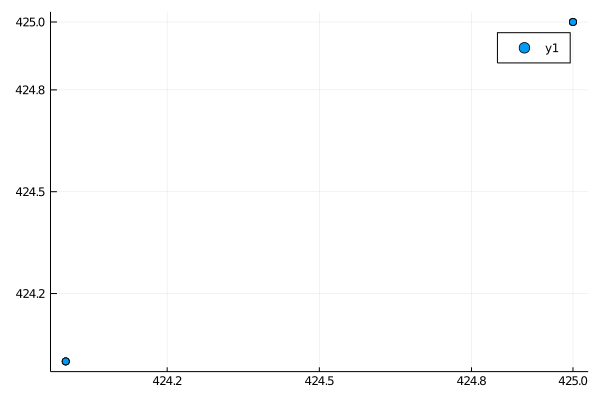

([424.0 431.0; 424.0 431.0; … ; 425.0 431.0; 425.0 431.0], ind([-0.9181464966525591, 0.7119263059387698, -0.5562324771791962, -0.512280507760353, 0.7421920463394173, -0.19443291104307414, -0.7212212882928246, -0.7518406982830655, 0.06760177857721061, 0.19370910709201666  …  1.6817296781604634, 0.6812035463683659, -0.8666565040531042, 0.10219351827125873, -0.6328846419684638, -0.686405260187597, -0.4113856953707252, -1.7156299088287517, -0.8033526842873332, 0.23749755850122564], [425, 431, 0, 0, 0]))

In [28]:
dx=0.05
dt=0.03
n = 100
n_gen = 10
taille_ind = N
taille_pop = 100

tr1 = track(n)
L = [1,2,4,2,3,4,2,2,2,4,2,2,2,2,4,3,4,1,4,2,2,3,2,2,1,2,4]
build!(tr1,L)

tr2 = track(n)
L = [1,2,3,4,2,4,2,4,2,3,2,2]
build!(tr2,L)

trMOP = [tr1,tr2]


ci=[52.,12.,0.]

P = ga(n_gen,taille_pop,taille_ind,trMOP,dt,dx,ci)

In [103]:
#plot(scatter(P[1][:,1],P[1][:,2]))
#plot(P[1][:,1] .+ P[1][:,2])

In [101]:
#affichage(P[2],tr1,dt,dx,ci);

In [73]:
tr3 = track(n)
L = [1,4,2,4,2,3,2,2]
build!(tr3,L)
plot(heatmap(tr3.road));

In [102]:
#affichage(P[2],tr3,dt,dx,ci);

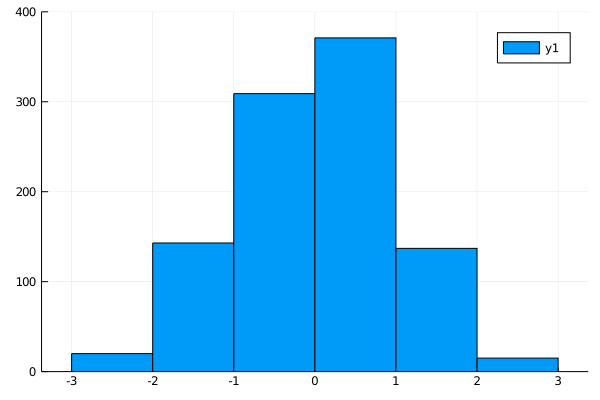

In [23]:

default(show=:ijulia)
bins = collect(-3:3); ylims = (0, 400)
p = histogram(randn(1000), bins = bins, ylims = ylims)

for i in 1:10
    h = histogram(randn(1000), bins = bins, ylims = ylims);
    p[1] = h.series_list[1][:x], h.series_list[1][:y]
    sleep(0.2)
    p
end